#  DDPG Crypto-Currency Trading

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [4]:
# assets=['kan','eos','wicc']
assets=assets=['bat','let','mds']
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='30min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data_default(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [537]:
class DDRPG(object):
    def __init__(self, s_dim,
                 asset_number,
                 buffer_size=64,
                 tau=0.05,
                 softmax_tau=1,
                 gamma=0.99,
                 actor_rnn_units=128,
                 critic_s_rnn_units=128,
                 critic_a_rnn_units=64,
                 actor_dnn_units=[32],
                 critic_s_dnn_units=[32,16],
                 critic_a_dnn_units=[32,16],
                 learning_rate_a=1e-3,
                 learning_rate_c=2e-3):
        tf.reset_default_graph()
        
        self.buffer_size = buffer_size
        self.pointer = 0
        self.asset_number = asset_number
        
        self.a_dim, self.s_dim = 1, s_dim
        self.tau = tau
        self.softmax_tau = softmax_tau
        self.gamma = gamma
        self.lr_a = learning_rate_a
        self.lr_c = learning_rate_c
        self.actor_rnn_units = actor_rnn_units
        self.critic_s_rnn_units = critic_s_rnn_units
        self.critic_a_rnn_units = critic_a_rnn_units
        
        self.actor_dnn_units = actor_dnn_units
        self.critic_a_dnn_units = critic_a_dnn_units
        self.critic_s_dnn_units = critic_s_dnn_units
        
        self.s_buffer = np.zeros((self.asset_number, self.buffer_size, self.s_dim))
        self.s_next_buffer = np.zeros((self.asset_number, self.buffer_size, self.s_dim))
        self.r_buffer = np.zeros((self.asset_number, self.buffer_size, 1))
        self.a_buffer = np.zeros((self.asset_number, self.buffer_size, self.a_dim))
        
        self.s = tf.placeholder(tf.float32, [None, None, self.s_dim], 's')
        self.s_next = tf.placeholder(tf.float32, [None, None, self.s_dim], 's_next')
        self.r = tf.placeholder(tf.float32, [None, None, 1], 'r')
        self.keep_prob = tf.placeholder(tf.float32, [], 'dropout')
        
#         with tf.variable_scope('actor', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
        with tf.variable_scope('actor', initializer=tf.truncated_normal_initializer(dtype=tf.float32,mean=0,stddev=1)):
            self.a = self._build_a(s=self.s,
                                   rnn_units=self.actor_rnn_units,
                                   dnn_units=self.actor_dnn_units,
                                   scope='predict',
                                   keep_prob=self.keep_prob,
                                   trainable=True)
            a_next = self._build_a(s=self.s_next,
                                   rnn_units=self.actor_rnn_units,
                                   dnn_units=self.actor_dnn_units,
                                   scope='target',
                                   keep_prob=self.keep_prob,
                                   trainable=False)
#         with tf.variable_scope('critic', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
        with tf.variable_scope('critic', initializer=tf.truncated_normal_initializer(dtype=tf.float32,mean=0,stddev=1)):
            q = self._build_c(s=self.s,
                              a=self.a,
                              s_rnn_units=self.critic_s_rnn_units,
                              a_rnn_units=self.critic_a_rnn_units,
                              s_dnn_units=self.critic_s_dnn_units,
                              a_dnn_units=self.critic_a_dnn_units,
                              scope='predict',
                              keep_prob=self.keep_prob,
                              trainable=True)
            q_next = self._build_c(s=self.s_next,
                                   a=a_next,
                                   s_rnn_units=self.critic_s_rnn_units,
                                   a_rnn_units=self.critic_a_rnn_units,
                                   s_dnn_units=self.critic_s_dnn_units,
                                   a_dnn_units=self.critic_a_dnn_units,
                                   scope='target',
                                   keep_prob=self.keep_prob,
                                   trainable=False)
        
        self.ap_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor/predict')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor/target')
        self.cp_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='critic/predict')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='critic/target')
        
        self.soft_replace = [[tf.assign(ta, (1 - self.tau) * ta + self.tau * pa),
                              tf.assign(tc, (1 - self.tau) * tc + self.tau * pc)]
                             for ta, pa, tc, pc in zip(self.at_params, self.ap_params, self.ct_params, self.cp_params)]
        
        q_target = self.r + self.gamma * q_next
        with tf.variable_scope('actor_loss'):
            a_loss = - tf.reduce_mean(q)
        with tf.variable_scope('critic_loss'):
            c_loss = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        with tf.variable_scope('actor_train'):
            self.a_train = tf.train.AdamOptimizer(self.lr_a).minimize(a_loss, var_list=self.ap_params)
        with tf.variable_scope('critic_loss'):
            self.c_train = tf.train.AdamOptimizer(self.lr_c).minimize(c_loss, var_list=self.cp_params)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def trade(self, train=False,kp=1.0,epsilon=0.9):
        action = self.sess.run(self.a, {self.s: self.s_buffer,self.keep_prob:kp})[:,self.pointer,:].flatten()
        if train:
            if np.random.rand()<epsilon:
                return action
            action = np.clip(np.random.normal(action, scale=(1-action)),0,1)
            action = np.exp(action / self.softmax_tau) / np.sum(np.exp(action / self.softmax_tau))
            return action
        else:
            return action
    
    def train(self, kp=0.85):
        self.sess.run(self.soft_replace)
        self.sess.run(self.a_train, {self.s: self.s_buffer,
                                     self.keep_prob: kp})
        self.sess.run(self.c_train, {self.s: self.s_buffer,
                                     self.a: self.a_buffer,
                                     self.r: self.r_buffer,
                                     self.s_next: self.s_next_buffer,
                                     self.keep_prob: kp})
    
    def save_current_state(self, s):
        if self.pointer < self.buffer_size - 1:
            self.s_buffer[:, self.pointer, :] = s
        else:
            self.s_buffer[:, :-1, :] = self.s_buffer[:, 1:, :]
            self.s_buffer[:, -1, :] = s
    
    def save_transition(self, a, r, s_next):
        if self.pointer < self.buffer_size - 1:
            self.a_buffer[:, self.pointer, :] = a[:, None]
            self.s_next_buffer[:, self.pointer, :] = s_next
            self.r_buffer[:, self.pointer, :] = r[:, None]
            self.pointer += 1
        else:
            self.a_buffer[:, :-1, :] = self.a_buffer[:, 1:, :]
            self.a_buffer[:, -1, :] = a[:, None]
            
            self.r_buffer[:, :-1, :] = self.r_buffer[:, 1:, :]
            self.r_buffer[:, -1, :] = r[:, None]
            
            self.s_next_buffer[:, :-1, :] = self.s_next_buffer[:, 1:, :]
            self.s_next_buffer[:, -1, :] = s_next
    
    def restore_buffer(self):
        self.s_buffer = np.zeros((self.asset_number, self.buffer_size, self.s_dim))
        self.s_next_buffer = np.zeros((self.asset_number, self.buffer_size, self.s_dim))
        self.r_buffer = np.zeros((self.asset_number, self.buffer_size, 1))
        self.a_buffer = np.zeros((self.asset_number, self.buffer_size, self.a_dim))
        self.pointer = 0
    
    def _build_a(self, s, rnn_units, dnn_units, scope, keep_prob, trainable):
        with tf.variable_scope(scope):
            cell = self._add_GRU(units_number=rnn_units, activation=tf.nn.tanh, keep_prob=keep_prob, trainable=trainable)
            out, _ = tf.nn.dynamic_rnn(inputs=s, cell=cell, dtype=tf.float32)
            out = self._add_dense_layer(inputs=out, output_shape=dnn_units + [1], activations=([tf.nn.relu] * (len(dnn_units)) + [None]), drop_keep_prob=keep_prob, trainable=trainable)
            out = tf.nn.softmax(out,axis=0)
            return out
    
    def _build_c(self, s, a, s_rnn_units, a_rnn_units, s_dnn_units, a_dnn_units, scope, keep_prob, trainable):
        with tf.variable_scope(scope):
            s_cell = self._add_GRU(units_number=s_rnn_units, activation=tf.nn.tanh, keep_prob=keep_prob, trainable=trainable)
            s_out, _ = tf.nn.dynamic_rnn(inputs=s, cell=s_cell, dtype=tf.float32, scope=scope + '/s')
            s_out = self._add_dense_layer(inputs=s_out, output_shape=s_dnn_units, activations=[tf.nn.relu] * len(s_dnn_units), drop_keep_prob=keep_prob, trainable=trainable)
            
            a_cell = self._add_GRU(units_number=a_rnn_units, activation=tf.nn.tanh, keep_prob=keep_prob, trainable=trainable)
            a_out, _ = tf.nn.dynamic_rnn(inputs=a, cell=a_cell, dtype=tf.float32, scope=scope + '/a')
            a_out = self._add_dense_layer(inputs=a_out, output_shape=a_dnn_units, activations=[tf.nn.relu] * len(a_dnn_units), drop_keep_prob=keep_prob, trainable=trainable)
            
            q = self._add_dense_layer(inputs=(a_out + s_out), output_shape=[1], activations=[tf.nn.tanh], drop_keep_prob=keep_prob, trainable=trainable)
            
            return q
    
    def _add_GRU(self, units_number, activation=tf.nn.relu, keep_prob=1.0, trainable=True):
        cell = tf.contrib.rnn.GRUCell(units_number, activation=activation)
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
        return cell
    
    def _add_dense_layer(self, inputs, output_shape, activations, drop_keep_prob, use_bias=True, trainable=True):
        output = inputs
        for n, a in zip(output_shape, activations):
            output = tf.layers.dense(output, n, activation=a, use_bias=use_bias, trainable=trainable)
            output = tf.nn.dropout(output, drop_keep_prob)
        return output

In [538]:
model=DDRPG(s_dim=asset_data.shape[2],asset_number=asset_data.shape[0],buffer_size=64)

In [539]:
normalize_length=10
train_length=1500
batch_size=60
c=1e-5
epoch=10
epsilon=0.5
train_r=[]
train_mean_r=[]
test_r=[]
test_mean_r=[]
model.restore_buffer()
for e in range(epoch):
    train_reward=[]
    test_reward=[]
    test_actions=[]
    previous_action=np.zeros(asset_data.shape[0])
    for t in range(normalize_length,train_length):
        data=asset_data[:,t-normalize_length:t,:].values
        state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        data=asset_data[:,t-normalize_length+1:t+1,:].values
        next_state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        model.save_current_state(s=state)
        action=model.trade(train=True,epsilon=epsilon)
        r=asset_data[:,:,'diff'].iloc[t].values*action-c*np.abs(previous_action-action)
        model.save_transition(a=action,r=r,s_next=next_state)
        previous_action=action
        train_reward.append(r)
        if t%32==0:
            model.train()
#         if t%batch_size==0:
#             model.train(drop=0.8)
#             model.restore_buffer()
    model.restore_buffer()
    print(e,'train_reward',np.sum(np.sum(train_reward,axis=1)),np.mean(train_reward))
    train_r.append(np.sum(np.sum(train_reward,axis=1)))
    train_mean_r.append(np.mean(train_reward))
    previous_action=np.zeros(asset_data.shape[0])
    for t in range(train_length,asset_data.shape[1]):
        data=asset_data[:,t-normalize_length:t,:].values
        state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        model.save_current_state(s=state)
        action=model.trade(train=False)
        r=asset_data[:,:,'diff'].iloc[t].values*action-c*np.abs(previous_action-action)
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
#         if t % batch_size==0:
#             model.restore_buffer()
    print(e,'test_reward',np.sum(np.sum(test_reward,axis=1)),np.mean(test_reward))
    test_r.append(np.sum(np.sum(test_reward,axis=1)))
    test_mean_r.append(np.mean(test_reward))
    model.restore_buffer()
    epsilon=epsilon**((epoch-e)/epoch)
    if np.sum(np.sum(test_reward,axis=1))>0.3: break
model.restore_buffer()


0 train_reward -0.2933197349348496 -6.56196275022035e-05
0 test_reward 0.2242748560597549 0.00018145214891565926
1 train_reward -0.11487922106621118 -2.5700049455528216e-05
1 test_reward 0.22584252116352416 0.00018272048637825577
2 train_reward 0.04514010217391806 1.0098456862174044e-05
2 test_reward 0.23045044065223386 0.00018644857657947728
3 train_reward -0.013966291963625366 -3.1244501037193337e-06
3 test_reward 0.26735268399454015 0.000216304760513382
4 train_reward -0.36946118317340726 -8.265350853991215e-05
4 test_reward 0.26793902707663625 0.00021677914812025579
5 train_reward -0.44418066610408125 -9.936927653335149e-05
5 test_reward 0.27281058001311315 0.00022072053399119186
6 train_reward -0.45816977893094174 -0.00010249883197560216
6 test_reward 0.27423174325128824 0.00022187034243631735
7 train_reward -0.3729591895814278 -8.343606030904428e-05
7 test_reward 0.27572785271746664 0.00022308078698824165
8 train_reward -0.5336987300525347 -0.00011939568904978403
8 test_reward 0.

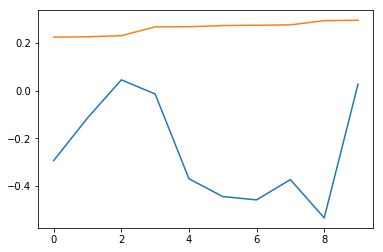

In [540]:
plt.plot(train_r)
plt.plot(test_r)

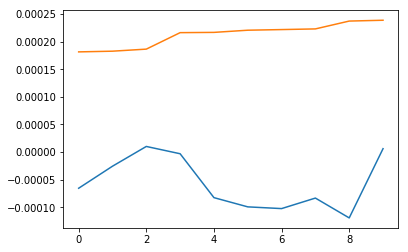

In [541]:
plt.plot(train_mean_r)
plt.plot(test_mean_r)

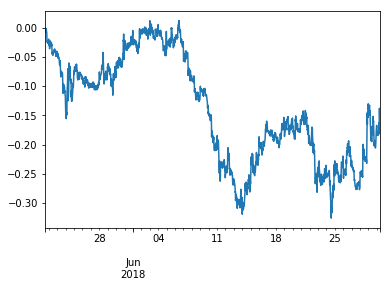

In [542]:
asset_data[:,:,'diff'].mean(axis=1).cumsum().plot()

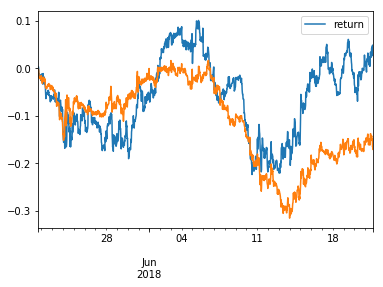

In [543]:
pd.DataFrame(np.sum(train_reward,axis=1),index=asset_data[:,normalize_length:train_length,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,normalize_length:train_length,'diff'].mean(axis=1).cumsum().plot()

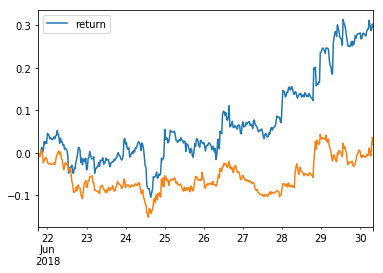

In [544]:
pd.DataFrame(np.sum(test_reward,axis=1),index=asset_data[:,train_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length:,'diff'].mean(axis=1).cumsum().plot()

In [545]:
np.sum(test_reward)

0.2951357564259582

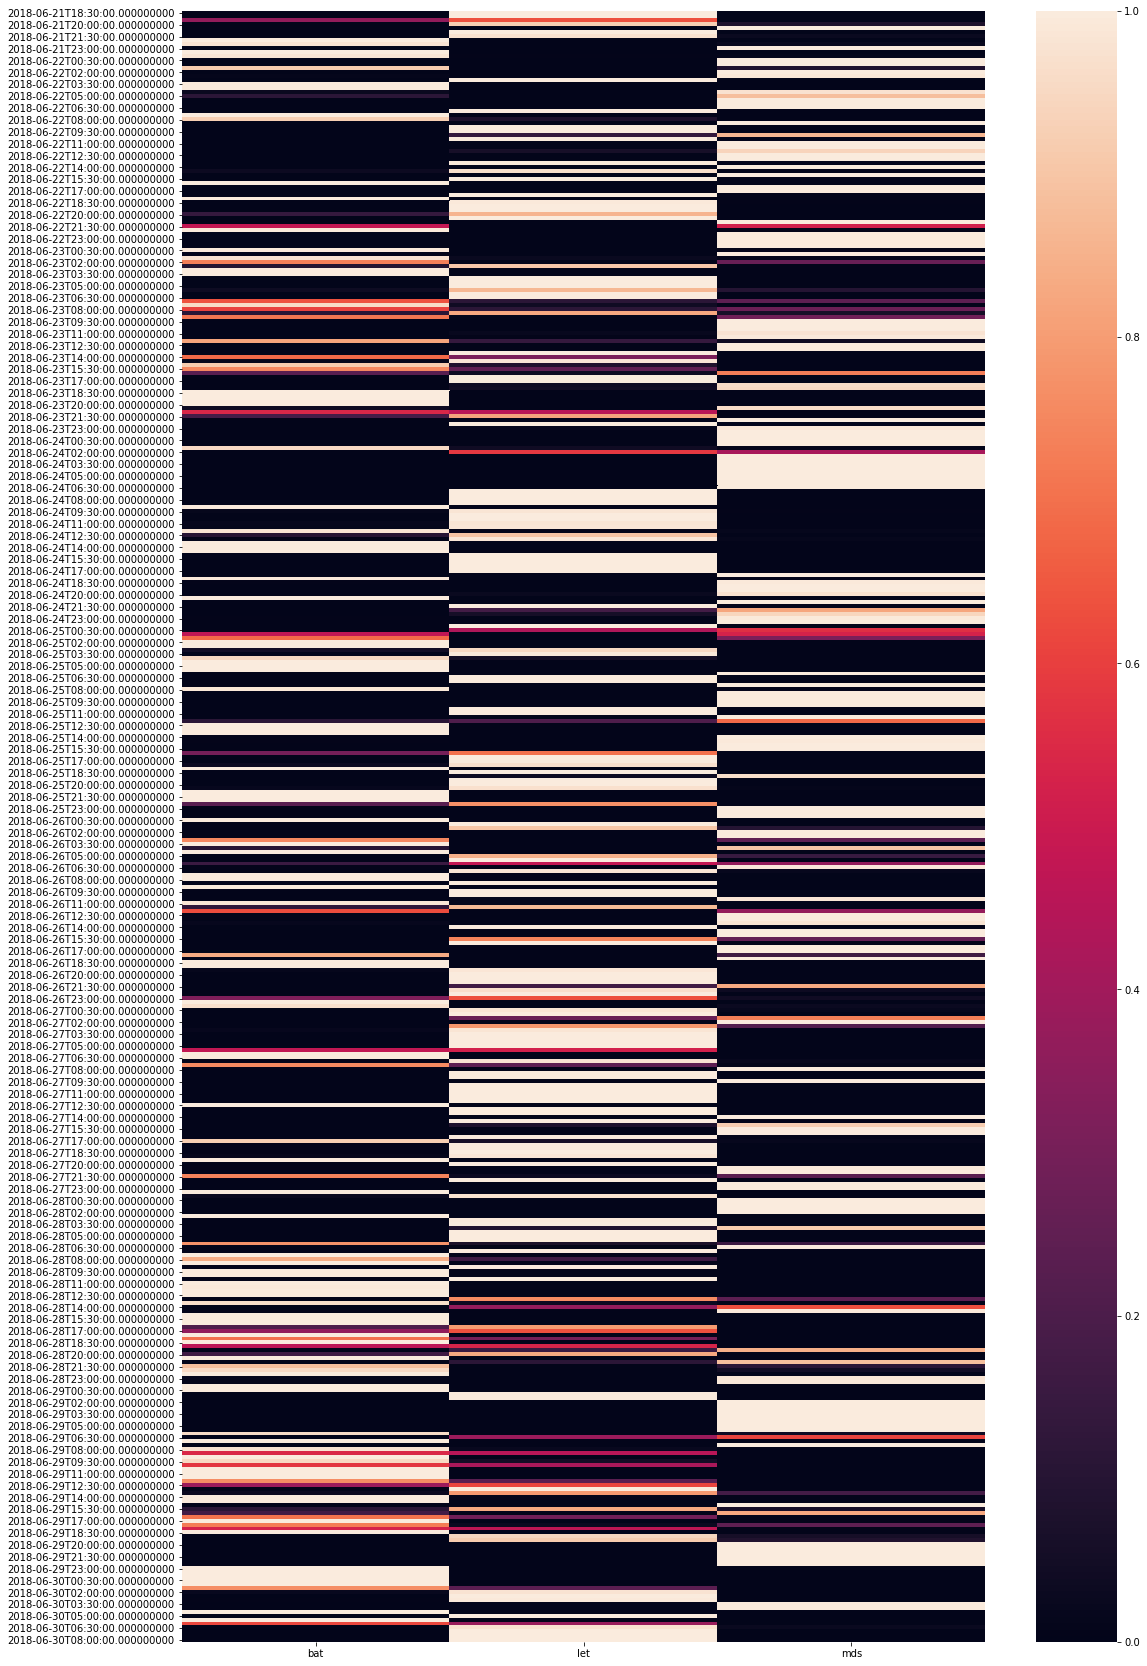

In [546]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length:,'diff'].index,columns=list(asset_data.items))
plt.figure(figsize=(18,30))
sns.heatmap(test_action_df)

In [547]:
np.abs(test_action_df.shift(1)-test_action_df).sum()

bat    130.560660
let    141.002925
mds    126.833676
dtype: float64